In [29]:
PROJECT_DIR = '/home/thanuja/Dropbox/capstone/'
APP_SYS_NAME = 'BGL'
#APP_SYS_NAME = 'Thunderbird'

In [30]:
BASE_DIR = PROJECT_DIR + 'output/'
RAW_DIR = PROJECT_DIR + 'raw_files/'

# Imports

In [31]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix , precision_score, recall_score, f1_score
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from scipy.spatial.distance import cosine
import warnings
import matplotlib.pyplot as plt
import sys
import subprocess
import random

random.seed(2)
sys.path.append(PROJECT_DIR) # this is done to make the import of ad_feature_extraction work
from ad_feature_extraction import parsers

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

# Preprocessing

Input_data Shape: (94000, 64)
label
False    86698
True      7302
Name: count, dtype: int64


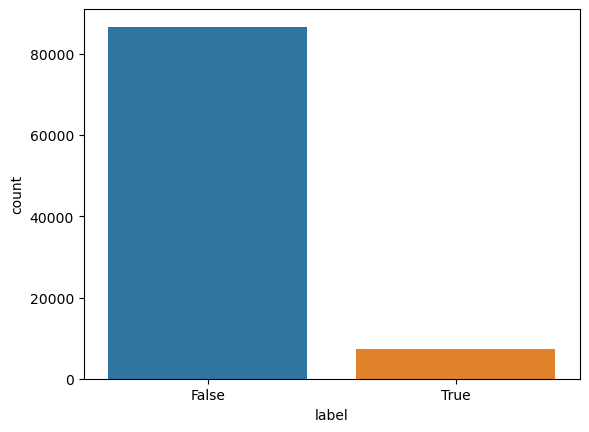

In [32]:
input_data = pd.read_csv(BASE_DIR + APP_SYS_NAME + '_clusters2.csv')

print("Input_data Shape:",input_data.shape)
print(input_data['label'].value_counts())

sns.countplot(x=input_data['label'])
plt.show()

In [33]:
le = LabelEncoder()
input_data['label'] = le.fit_transform(input_data['label']) # false:0 and true:1

X = input_data[['tfidf_text']].dropna()
y = input_data.loc[X.index,'label'].values

print("columns for the X file"+ str(X.columns))
print(X.shape,y.shape)

columns for the X fileIndex(['tfidf_text'], dtype='object')
(94000, 1) (94000,)


In [34]:
# do tfidf and kmeans on input_data and get homegeneity and completeness scores.
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X['tfidf_text'])
print('tfidf shape', X_tfidf.shape)

k = input_data['cluster2'].max() + 1
print('Using k = ', k)
kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, batch_size=10000, random_state=0)
# KMeans(k, random_state=0)
kmeans.fit(X_tfidf)

pred = kmeans.predict(X_tfidf)
labels = y

print("_______________________________________________")
print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n") 

tfidf shape (94000, 1344)
Using k =  42
_______________________________________________
Completeness Score: 
 0.10056973397985698

Homogeneity Score: 
 0.9920274152504349



In [35]:
# count log lines within each cluster
output = X.copy()
output['cluster2'] = pred
output['label'] = input_data.loc[X.index, 'label']
print(output.groupby(['cluster2', 'label']).count())

                tfidf_text
cluster2 label            
0        0            7376
1        0             443
2        1            5004
3        0            4729
4        0            6077
5        0            1985
6        0            1987
7        0             658
8        0            2010
9        0             950
10       0             749
11       0            1576
12       0            1559
13       0             939
14       1             905
15       0             960
16       0            1475
17       1             876
18       0            2407
19       0             843
20       0             628
21       0             948
22       1             477
23       0             564
24       0             505
26       0            1169
27       0             419
28       0             638
30       0             500
31       0             523
32       0             670
33       0             449
34       0             321
35       0            1202
         1               7
3

# Use label to determine which clusters are anomalies

In [36]:
print(output.groupby(['cluster2', 'label']).count())
counts_by_label_df = output.groupby(['cluster2', 'label']).count().reset_index()
pos_df = counts_by_label_df[counts_by_label_df['label'] == 1]
neg_df = counts_by_label_df[counts_by_label_df['label'] == 0]
anomaly_clusters = []
normal_clusters = []
for _, row in pos_df.iterrows():
    cluster = row['cluster2']
    pos = row['tfidf_text']
    neg = neg_df[neg_df["cluster2"] == cluster]['tfidf_text'].sum()
    print(cluster, 'pos neg', pos, neg)
    if pos > neg:
        anomaly_clusters.append(cluster)

for _, row in neg_df.iterrows():
    cluster = row['cluster2']
    neg = row['tfidf_text']
    pos = pos_df[pos_df["cluster2"] == cluster]['tfidf_text'].sum()
    if neg >= pos:
        normal_clusters.append(cluster)

print('anomaly clusters', anomaly_clusters)
print('normal clusters', normal_clusters)

                tfidf_text
cluster2 label            
0        0            7376
1        0             443
2        1            5004
3        0            4729
4        0            6077
5        0            1985
6        0            1987
7        0             658
8        0            2010
9        0             950
10       0             749
11       0            1576
12       0            1559
13       0             939
14       1             905
15       0             960
16       0            1475
17       1             876
18       0            2407
19       0             843
20       0             628
21       0             948
22       1             477
23       0             564
24       0             505
26       0            1169
27       0             419
28       0             638
30       0             500
31       0             523
32       0             670
33       0             449
34       0             321
35       0            1202
         1               7
3

# Create summary report for clusters. Give example log line for each cluster.

In [37]:
summary_file_name = BASE_DIR + APP_SYS_NAME + '_cluster_summary.csv'
output_file = open(summary_file_name, 'w')
with output_file:
    writer = csv.writer(output_file)
    writer.writerow(['is_anomaly', 'anomaly_count', 'normal_count',
                     'cluster', 'pct_of_total',
                     'most_similar_sample', 'most_similar_distance',
                     'least_similar_sample', 'least_similar_distance'])
    
    def print_clusters(clusters, label):
        num_rows = X.shape[0]
        for ac in clusters:
            indices = X.index[pred == ac]
            rows_for_cluster = X_tfidf[pred == ac]
            centroid = kmeans.cluster_centers_[ac]
            least_distance = 0
            most_similar = None
            greatest_distance = 1
            least_similar = None
            for i in range(rows_for_cluster.shape[0]):
                row = np.asarray(rows_for_cluster[i].todense()).reshape(-1)
                distance = cosine(centroid, row)
                if most_similar is None or least_distance > distance:
                    least_distance = distance
                    most_similar = i
        
                if least_similar is None or greatest_distance < distance:
                    greatest_distance = distance
                    least_similar = i
                
            pct = round(np.count_nonzero(pred == ac) / num_rows, 2)
            writer.writerow([1 if label == 'anomaly' else 0,
                             pos_df[pos_df["cluster2"] == ac]['tfidf_text'].sum(),
                             neg_df[neg_df["cluster2"] == ac]['tfidf_text'].sum(),
                             ac, pct,
                             input_data.loc[indices[most_similar], 'text'], round(least_distance, 3),                  
                             input_data.loc[indices[least_similar], 'text'], round(greatest_distance, 3)])
    print_clusters(anomaly_clusters, 'anomaly')
    print_clusters(normal_clusters,  ' normal')
    
summary_df = pd.read_csv(summary_file_name)
summary_df

,is_anomaly,anomaly_count,normal_count,cluster,pct_of_total,most_similar_sample,most_similar_distance,least_similar_sample,least_similar_distance
0,1,5004,0,2,0.05,RAS KERNEL FATAL data TLB error interrupt,0.000,RAS KERNEL FATAL data TLB error interrupt,0.000
1,1,905,0,14,0.01,RAS KERNEL FATAL data storage interrupt,0.000,RAS KERNEL FATAL data storage interrupt,0.000
2,1,876,0,17,0.01,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000,RAS KERNEL FATAL Lustre mount FAILED : bglio88...,0.000
3,1,477,0,22,0.01,RAS KERNEL FATAL rts: kernel terminated for re...,0.018,RAS KERNEL FATAL rts: kernel terminated for re...,0.434
4,0,0,7376,0,0.08,RAS KERNEL INFO iar 003a929c dear 012987f8,0.000,RAS KERNEL INFO iar 003a929c dear 012987f8,0.000
5,0,0,443,1,0.00,RAS KERNEL INFO generating core.7,0.128,RAS KERNEL INFO generating core.7,0.128
6,0,0,4729,3,0.05,RAS MMCS ERROR idoproxydb hit ASSERT condition...,0.000,RAS MMCS ERROR idoproxydb hit ASSERT condition...,0.000
7,0,0,6077,4,0.06,RAS KERNEL INFO 8 floating point alignment exc...,0.000,RAS KERNEL INFO 8 floating point alignment exc...,0.000
8,0,0,1985,5,0.02,RAS KERNEL INFO 0 microseconds spent in the rb...,0.000,RAS KERNEL INFO 0 microseconds spent in the rb...,0.000
9,0,0,1987,6,0.02,RAS KERNEL INFO 10692 total interrupts. 0 crit...,0.000,RAS KERNEL FATAL critical input interrupt enab...,0.364


# Mispredictions

In [46]:
for ac in anomaly_clusters:
    indices = input_data.index[(pred == ac) & (input_data['label'] == 0)]
    if indices.size == 0:
        continue
    print('False Positives for cluster', ac, 'count', indices.size)
    print(np.unique(input_data.loc[indices, 'text'].values))
    print(np.unique(input_data.loc[indices, 'tfidf_text'].values))

for nc in normal_clusters:
    indices = input_data.index[(pred == nc) & (input_data['label'] == 1)]
    if indices.size == 0:
        continue
    print('False Negatives for cluster', nc, 'count', indices.size)
    print(np.unique(input_data.loc[indices, 'text'].values))
    print(np.unique(input_data.loc[indices, 'tfidf_text'].values))

False Negatives for cluster 35 count 7
['RAS APP FATAL external input interrupt (unit=0x02 bit=0x00): uncorrectable torus error'
 'RAS KERNEL FATAL machine check interrupt (bit=0x06): L3 major internal error'
 'RAS KERNEL FATAL rts panic! - stopping execution']
['RAS APP FATAL    (= =):   ' 'RAS KERNEL FATAL     '
 'RAS KERNEL FATAL    (=): L3   ']
False Negatives for cluster 38 count 33
['RAS APP FATAL ciod: Error creating node map from file ./map-xyzt-8x8x16x1-2-mid: No child processes'
 'RAS KERNEL FATAL DDR machine check register: 0x00000000 0x00010000']
['RAS APP FATAL ciod: Error      /-xyzt-8x8x16x1-2-mid: No  '
 'RAS KERNEL FATAL DDR machine check :  x1']


# Use TFIDF and KMeans from above to predict anomalies in original raw file

In [39]:
cluster_to_label_map = np.zeros(k)
for c in anomaly_clusters:
    cluster_to_label_map[c] = 1
    
for c in normal_clusters:
    cluster_to_label_map[c] = 0

mispredictions_file_name = BASE_DIR + APP_SYS_NAME + '_mispredictions.csv'
output_file = open(summary_file_name, 'w')

def process_raw_file(raw_filename, parser):
    block_size = 100000 # entire dataset will not fit in memory, so do a block at a time
    file_path = raw_filename.split('/')
    with open(raw_filename, "r", encoding="utf8", errors='ignore') as raw_file:
        count = 0
        fp_total = tp_total = fn_total = 0
        row_block = []
        y_block = np.zeros(block_size)
        for line in raw_file:
            line = line.rstrip('\n')
            epochts,text,is_anomaly,filename = parser(file_path, line)
            y_block[count % block_size] = 1 if is_anomaly else 0
            count += 1
            row_block.append(text)
            
            if count % block_size == 0:
                X_block = tfidf.transform(row_block)
                block_clusters = kmeans.predict(X_block)
                block_pred = np.zeros(block_size)
                for i in range(block_clusters.shape[0]):
                    block_pred[i] = cluster_to_label_map[block_clusters[i]]
                        
                fp = (block_pred == 1) & (y_block == 0)
                tp = (block_pred == 1) & (y_block == 1)
                fn = (block_pred == 0) & (y_block == 1)
                fp_total += np.count_nonzero(fp)
                tp_total += np.count_nonzero(tp)
                fn_total += np.count_nonzero(fn)
                print(count, fp_total, tp_total, fn_total)
                row_block = []

            # Remove this condition to process full file.
            if count > 3000000: break
        print(raw_filename, 'precision', tp_total / (fp_total + tp_total))
        print(raw_filename, 'recall', tp_total / (fn_total + tp_total))

process_raw_file(RAW_DIR + APP_SYS_NAME + '/' + APP_SYS_NAME + '.log', parsers[APP_SYS_NAME])

100000 1 477 2132
200000 1919 477 2292
300000 1922 77342 2299
400000 2386 169043 3324
500000 2386 203523 3324
600000 2386 216147 3324
700000 2386 216147 3324
800000 2387 216147 5374
900000 2396 216147 8756
1000000 2397 216147 8774
1100000 2398 216147 8781
1200000 2399 216147 8830
1300000 2400 216147 9026
1400000 2404 216659 9035
1500000 2404 216659 9035
1600000 2410 217308 10634
1700000 2410 217308 10634
1800000 2410 217308 10634
1900000 2410 217308 10635
2000000 2412 217914 10819
2100000 2415 217914 10830
2200000 2415 217914 10830
2300000 2415 219018 10830
2400000 2417 219018 10834
2500000 2425 220754 10936
2600000 2425 220754 10936
2700000 2427 220754 10940
2800000 2431 220929 10950
2900000 2431 220929 10950
3000000 2450 221575 12335
/home/thanuja/Dropbox/capstone/raw_files/BGL/BGL.log precision 0.9890637205669011
/home/thanuja/Dropbox/capstone/raw_files/BGL/BGL.log recall 0.9472660424949767


# Compute precision, recall, homogeneity, confusion matrix

BGL Result:
Accuracy Score: 99.96%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999539     1.000000  0.999574      0.999769      0.999575
recall         1.000000     0.994522  0.999574      0.997261      0.999574
f1-score       0.999769     0.997254  0.999574      0.998511      0.999574
support    86698.000000  7302.000000  0.999574  94000.000000  94000.000000
_______________________________________________
Confusion Matrix: 
 [[86698     0]
 [   40  7262]]

_______________________________________________
Completeness Score: 
 0.10056973397985698

_______________________________________________
Homogeneity Score: 
 0.9920274152504349

_______________________________________________
F1 Score: 
 0.9972535017852238
_______________________________________________
Precision Score: 
 1.0
_______________________________________________
Recall Score: 
 0.994522048753766
_______

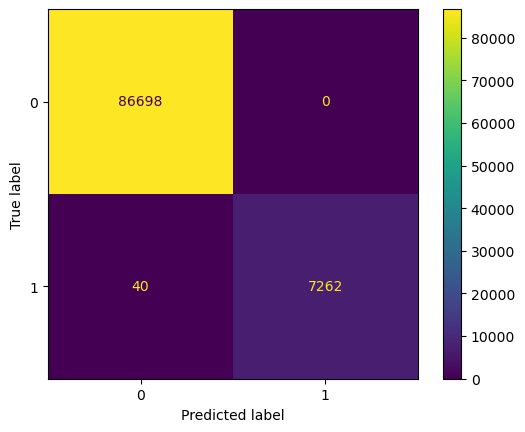

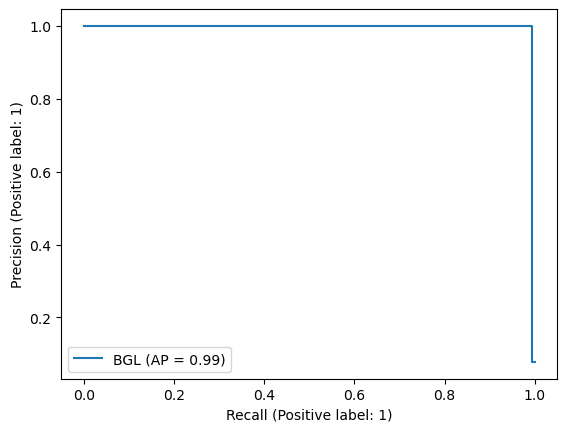

In [40]:
def report(report_name, pred, labels):
    label_pred = np.zeros(pred.size)
    for i in range(pred.size):
        label_pred[i] = cluster_to_label_map[pred[i]]
    kmeans_report = pd.DataFrame(classification_report(labels, label_pred, output_dict=True))
    print(f"{report_name} Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(labels, label_pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{kmeans_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(labels, label_pred)}\n")
    
    print("_______________________________________________")
    print(f"Completeness Score: \n {completeness_score(labels, pred)}\n")
    print("_______________________________________________")
    print(f"Homogeneity Score: \n {homogeneity_score(labels, pred)}\n")
    print("_______________________________________________")
    print(f'F1 Score: \n {f1_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Precision Score: \n {precision_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Recall Score: \n {recall_score(labels, label_pred)}')
    print("_______________________________________________")
    print(f'Roc AUC Score: \n {roc_auc_score(labels, label_pred)}')
   
    ConfusionMatrixDisplay.from_predictions(labels, label_pred)
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(labels, label_pred, name=report_name)
    plt.show()

report(APP_SYS_NAME, pred, output.label.values)

# TSNE Scatterplot

94000


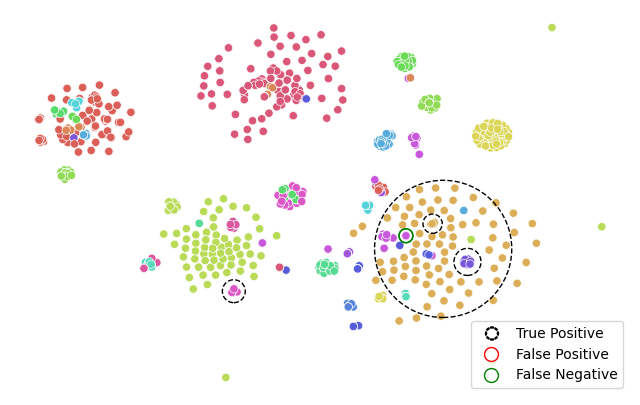

In [41]:
from sklearn.manifold import TSNE
import seaborn as sns

tfidf_tsne = TfidfVectorizer()
X_tfidf_tsne = tfidf_tsne.fit_transform(input_data.loc[X.index, 'text'])

print(output.shape[0])
output_sample = output.sample(1500, random_state=0)
X_tfidf_sample = X_tfidf_tsne[output_sample.index]
#print(np.bincount(output_sample['cluster2']))

for perplexity in range(35, 36, 5):
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=1000, learning_rate='auto', random_state=1, init="random")
    tsne_result = tsne.fit_transform(np.asarray(X_tfidf_sample.todense()))
    #tsne_result = tsne.fit_transform(X_tfidf_sample)

    #print(tsne_result)
    plt.figure(figsize=(8,5))


    tsne_df = output_sample.copy()
    tsne_df['tsne_one'] = tsne_result[:,0]
    tsne_df['tsne_two'] = tsne_result[:,1]

    ax= sns.scatterplot(
        x='tsne_one', y='tsne_two',
        hue="cluster2",
        #edgecolor=sns.color_palette("hls", 20),
        palette=sns.color_palette("hls", 20),
        #palette=sns.color_palette("blend:white,white"),
        data=tsne_df,
        legend=None,
        alpha=1,
        #s=70, facecolor='none', linewidth=1.5
    )
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    ax.set_frame_on(False)

    #sns.move_legend(ax, "center right")
    label_df = tsne_df[tsne_df['label'] == 1]
    
    legend_elements = [Line2D([0], [0], marker=u'$\u25CC$', color='white', markeredgecolor='black', label='True Positive', markerfacecolor='white', markersize=10, alpha=1),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='red', label='False Positive', markerfacecolor='white', markersize=10),
                       Line2D([0], [0], marker='o', color='white', markeredgecolor='green', label='False Negative', markerfacecolor='white', markersize=10)]
    ax.legend(handles=legend_elements, loc='lower right')

    tsne_centers = np.zeros((kmeans.cluster_centers_.shape[0], 2))
    tsne_radius = np.zeros(kmeans.cluster_centers_.shape[0])
    for i in range(kmeans.cluster_centers_.shape[0]):
        tsne_cluster = tsne_result[output_sample.cluster2 == i]
        if tsne_cluster.sum() == 0: continue
        tsne_centers[i] = np.mean(tsne_cluster, axis=0)
        #print(i, np.max(tsne_cluster, axis=0))
        tsne_radius[i] = np.max(np.max(tsne_cluster, axis=0) - np.min(tsne_cluster, axis=0))
    anomaly_tsne_centers = tsne_centers[anomaly_clusters]
    anomaly_tsne_radius = tsne_radius[anomaly_clusters]
    #print(anomaly_tsne_radius)
    #anomaly_tsne_centers = anomaly_tsne_centers[anomaly_tsne_radius < 75]
    #anomaly_tsne_radius = anomaly_tsne_radius[anomaly_tsne_radius < 75]
    plt.scatter(anomaly_tsne_centers[:, 0], anomaly_tsne_centers[:, 1], s=anomaly_tsne_radius*200,
                facecolors='none', edgecolors='black', linestyle='dashed')
    
    #true_positives = tsne_result[output_sample.cluster2.isin(anomaly_clusters) & (output_sample.label == 1)]
    #plt.scatter(true_positives[:, 0], true_positives[:, 1], s=100, facecolors='none', edgecolors='black', alpha=0.1)
    
    false_negatives = tsne_result[output_sample.cluster2.isin(normal_clusters) & (output_sample.label == 1)]
    #print(false_positives)
    plt.scatter(false_negatives[:, 0], false_negatives[:, 1], s=100, facecolors='none', edgecolors='green')
    
    false_positives = tsne_result[output_sample.cluster2.isin(anomaly_clusters) & (output_sample.label == 0)]
    #print(false_negatives)
    plt.scatter(false_positives[:, 0], false_positives[:, 1], s=100, facecolors='none', edgecolors='red')
    
    
    plt.show()


# Predictability

In [42]:
window_df = pd.DataFrame()
cluster_seq = input_data[['cluster2']].values
#cluster_seq = np.arange(50)
y_df = np.squeeze(cluster_seq)

print('uniq clusters', np.unique(y_df))

for w in range(1, 6):
    if w == 0:
        continue
    col = "w+" + str(w)
    padding = np.ones((1, w)) * -1
    window_df[col] = np.append(cluster_seq[w:], padding)

n = len(cluster_seq)
for w in range(1, 6):
    if w == 0:
        continue
    col = "w-" + str(w)
    padding = np.ones((1, w)) * -1
    window_df[col] = np.append(padding, cluster_seq[:n-w])

    
print(window_df.head(10))
print('window', window_df.shape, 'y_df', y_df.shape)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(window_df, y_df)
print('classes', gnb.classes_)

idx = np.ones(gnb.classes_.max() + 1).astype(int) * -1
for i, c in enumerate(gnb.classes_):
    idx[c] = i

print('idx', idx)

print('priors', gnb.class_prior_)

probs = gnb.predict_proba(window_df)
pred_probs = np.zeros(probs.shape[0])
for i in range(probs.shape[0]):
    col = idx[y_df[i]]
    pred_probs[i] = probs[i, col]


prob_totals = np.zeros(probs.shape[1])
prob_counts = np.zeros(probs.shape[1])
for i in range(probs.shape[1]):
    cls = gnb.classes_[i]
    prob_totals[i] = pred_probs[y_df == cls].sum()
    prob_counts[i] = np.count_nonzero(y_df == cls)
    print('probs', i, cls, prob_totals[i], prob_counts[i])

predictiveness = prob_totals / prob_counts
print(predictiveness)
print(np.argsort(predictiveness))


for i in anomaly_clusters:
    print('anomaly cluster', i, 'predictiveness', predictiveness[idx[i]])

for i in normal_clusters:
    print('normal cluster', i, 'predictiveness', predictiveness[idx[i]])


uniq clusters [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41]
    w+1   w+2   w+3   w+4   w+5   w-1   w-2   w-3   w-4   w-5
0  12.0  12.0  12.0  12.0  12.0  -1.0  -1.0  -1.0  -1.0  -1.0
1  12.0  12.0  12.0  12.0  12.0  12.0  -1.0  -1.0  -1.0  -1.0
2  12.0  12.0  12.0  12.0  12.0  12.0  12.0  -1.0  -1.0  -1.0
3  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  -1.0  -1.0
4  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  -1.0
5  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0
6  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0
7  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0
8  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0
9  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0
window (94000, 10) y_df (94000,)
classes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41]
idx [ 0  1  2  3  4  5 

In [43]:
from scipy.stats import kurtosis, skew

num_clusters = input_data['cluster2'].max() + 1
stats_df = pd.DataFrame({'cluster': [j for j in range(num_clusters)]})

kurt_results = []
skew_results = []

offset = 0
block_size = 10000
while offset < len(input_data):
    block_df = input_data.iloc[offset:offset+block_size]
    mean_timestamp = block_df['timestamp'].mean()
    offset += block_size
    for k in range(num_clusters):
        block = block_df[block_df['cluster2'] == k]['timestamp'].values - mean_timestamp
        if len(block) == 0:
            b_kurt = b_skew = 0
        else:
            b_kurt = kurtosis(block)
            b_skew = skew(block)
        kurt_results.append((b_kurt, k))
        skew_results.append((b_skew, k))

kurt_results = sorted(kurt_results, reverse=True)
skew_results = sorted(skew_results, reverse=True)
#print('kurt', [k for _, k in kurt_results])
#print('skew', [k for _, k in skew_results])


min_timestamp = input_data['timestamp'].min()

def cluster_dist(k):
    result = input_data[input_data['cluster2'] == k]['timestamp'] - min_timestamp
    if result.size == 0:
        result = input_data['timestamp'] - min_timestamp
    np_result = np.asarray(result.values)
    mean = np_result.mean()
    std = np_result.std()
    np_result = (np_result - mean) / std
    stats_df.at[k, 'kurtosis'] = kurtosis(np_result)
    stats_df.at[k, 'skew'] = skew(np_result)

#print(cluster_seq)
for k in range(num_clusters):
    cluster_dist(k)

stats_df.dropna()
print(input_data[['cluster2', 'label', 'clusters']].groupby(['cluster2', 'label']).count())
for col in stats_df.columns:
    print(col, np.argsort(stats_df[col].values))

#print('kurtosis', np.argsort(stats_df['kurtosis'].values))
#print('skew', np.argsort(stats_df['skew'].values))
print(stats_df['kurtosis'])
print(stats_df['skew'])

                clusters
cluster2 label          
0        0          1169
1        0           443
2        1          5004
3        0          6077
4        0          4729
5        0          1985
6        0           558
7        0          7376
8        0          1987
9        0           950
10       0          2010
11       1           876
12       0          1763
         1            32
13       0          3254
14       0          1576
15       0           939
16       0           523
17       0           960
18       0           701
19       0           843
20       0         35470
21       0           749
22       0          2407
25       0           564
26       1           477
27       0           505
28       1           905
29       0           519
30       0          1558
31       0           670
32       0           638
33       0           449
34       0           991
35       0           500
36       0          1000
37       0           329
         1             6


In [44]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

random_state=5

for ModelClass in [IsolationForest, SGDOneClassSVM]:
    model = ModelClass(random_state=random_state)
    model_pred = model.fit_predict(X_tfidf)
    model_pred[model_pred == 1] = 0
    model_pred[model_pred == -1] = 1
    model_name = type(model).__name__
    print("_______________________________________________")
    print(f"{model_name}:")
    print(f"Completeness Score: \n {completeness_score(model_pred, pred)}\n")
    print(f"Homogeneity Score: \n {homogeneity_score(model_pred, pred)}\n")

_______________________________________________
IsolationForest:
Completeness Score: 
 0.0

Homogeneity Score: 
 1.0

_______________________________________________
SGDOneClassSVM:
Completeness Score: 
 0.23522030907430244

Homogeneity Score: 
 0.965375789886589

